# Explaining Outcomes from a Multi-Class Classifier

This notebook demonstrates how SLISE can be used to explain outcomes from complex models on high-dimensional and multi-class data.
To this end we use a dataset of handwritten digits and a convolutional neural network.

### Considerations

SLISE works with vectors and linear models. This means that it discards the spatial information of images (and cannot consider translations). Additionally, the visualisation of linear models on colour images is challenging.
Thus, SLISE should normally not be used, **as such**, on images. However, this dataset is a special case since all the images are black-and-white and have been rotated, centered, and scaled, which removes much of the spatial variation. Furthermore, there is lots of overlapping information in adjacent pixels.

## Prerequisites

The example in this notebook assumes that SLISE is installed, which can be done with:
```sh
pip install https://github.com/edahelsinki/pyslise
```
We also need Keras (Tensorflow) for the neural network (and data):

In [1]:
import numpy as np
from tensorflow import keras
import slise
from slise.plot import BW_COLORMAP
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

plt.rcParams['figure.figsize'] = [10, 6]

## Dataset

Here we use the standard MNIST dataset. Note the use of label smoothing to combat overconfidence.

In [81]:
# Data parameters
num_classes = 10
label_smoothing = 0.2

# the data, split between train and test sets
(x_train, c_train), (x_test, c_test) = keras.datasets.mnist.load_data()
x_train.shape = (-1, 28, 28, 1)
x_test.shape = (-1, 28, 28, 1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(c_train, num_classes)
y_test = keras.utils.to_categorical(c_test, num_classes)

# Apply label smoothing
if label_smoothing > 0:
    y_train = y_train * (1.0 - label_smoothing) + label_smoothing / num_classes

# Scale images to the [-1, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

## Model

As the black box model we use a simple convolutional neural network. The code is adapted from: [https://keras.io/examples/vision/mnist_convnet/](https://keras.io/examples/vision/mnist_convnet/).

In [82]:
# Define the model
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [83]:
# Training parameters
batch_size = 128
epochs = 5

# Train the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/5
422/422 [==============================] - 12s 28ms/step - loss: 1.1717 - accuracy: 0.8935 - val_loss: 0.9844 - val_accuracy: 0.9808
Epoch 2/5
422/422 [==============================] - 12s 27ms/step - loss: 1.0103 - accuracy: 0.9714 - val_loss: 0.9574 - val_accuracy: 0.9855
Epoch 3/5
422/422 [==============================] - 12s 27ms/step - loss: 0.9893 - accuracy: 0.9774 - val_loss: 0.9463 - val_accuracy: 0.9887
Epoch 4/5
422/422 [==============================] - 12s 28ms/step - loss: 0.9782 - accuracy: 0.9811 - val_loss: 0.9391 - val_accuracy: 0.9893
Epoch 5/5
422/422 [==============================] - 12s 27ms/step - loss: 0.9702 - accuracy: 0.9833 - val_loss: 0.9345 - val_accuracy: 0.9900
Test loss: 0.26264718174934387
Test accuracy: 0.9889000058174133


## Explanation

To create explanations with SLISE we need a dataset of predictions (here we use the test-set mostly because it is smaller). Since SLISE cannot handle multiple classes at the same time we have to explain them one by one. Alternatively we could also just look at the predicted class (i.e. "why was this item predicted to be in this class"), which is what we do here.

Normally, it is a good idea to normalise the data matrix, but in this case the pixel values are already guaranteed to be in $[0, 1]$. So, the only thing we need to do is to flatten the images into vectors. We also subsample the dataset such that 50% of the images are of the same digit as the image we are explaining and 50% are of other digits.

In [97]:
digit = 0

# Balance the classes
mask = (c_test == digit) + (np.random.uniform(0, 1, len(c_test)) < 1 / num_classes)
x_explain = np.reshape(x_test[mask, :, :, :], (-1, 28 * 28))

# Extract predictions
p_test = model.predict(x_test)
p_explain = p_test[mask, digit]

We also need to select which image to explain. 

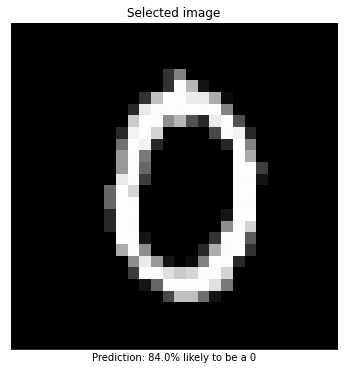

In [98]:
# Select item
item =  np.where(c_test[mask] == digit)[0][12]

# Show the selected item
plt.imshow(x_test[mask][item,:,:,0], cmap=BW_COLORMAP)
plt.xticks([])
plt.yticks([])
plt.title("Selected image")
plt.xlabel(f"Prediction: {p_test[mask][item, digit] * 100:.1f}% likely to be a {digit}")
plt.show()

The last activation function of a (classifier) neural network is often either a `sigmoid` or a `softmax`. These transform values from real space into (pseudo) probabilities. The non-linearity of `sigmoid` and `softmax` decreases the differences between the predictions (especially around zero and one). This squeezing makes the creation of explanations slightly more difficult. Additionally, SLISE gives explanations in the form of linear approximations, so it is benefitial if the predictions are in real space. Thus, it is recommended to reverse the final `sigmoid` or `softmax`.

The `sigmoid` function has an unique inverse in the `logit` function (and SLISE can do this inversion for us if we specify `logit=True` as a parameter). However, the `softmax` function does not have an unique inverse. The inverse is $log(x) + c$, where $c$ is a constant. Here we (arbitrarily) choose $c$ to be the negation of the median:

In [99]:
# Invert the softmax
y_explain = np.log(p_explain)
y_explain -= np.median(y_explain)

Now we can use SLISE to explain why this image is predicted to be a zero (the warning about maximum iterations can in most cases be safely ignored):

In [173]:
explanation = slise.explain(x_explain, y_explain, epsilon=0.3, x=x_explain[item], y=y_explain[item], lambda1=0.2, lambda2 = 0.1)

C:\Users\anton\miniconda3\envs\slise\lib\site-packages\slise\optimisation.py:190: SliseWarning: An optimisation step reaches the maximum number of iterations.
  warn(


First we need to do a quick sanity check to make sure that the explanation considers both classes. Otherwise the approximation is likely to be close to constant (probably due to too strong regularisation), which would be a poor explanation:

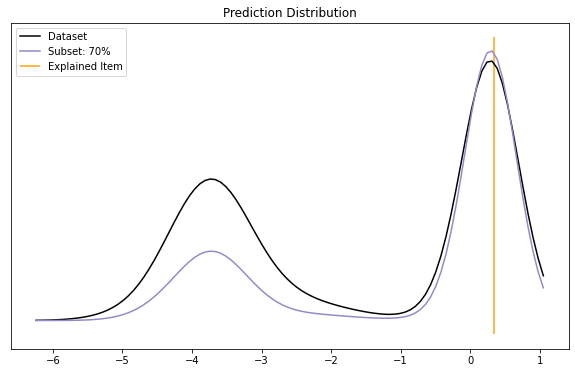

In [174]:
explanation.plot_subset()

Now we can look at the actual explanation. Keep in mind that the neural network sees the images as pixels (while humans might see them as, e.g., pen strokes). Thus, we should expect an explanation in terms of pixels. The explanation consists of a local approximation of the black box model (neural network) using a linear model. This means that, for each pixel, the explanation tells us whether a white pixel supports or disputes the classification (and vice versa for black pixels).

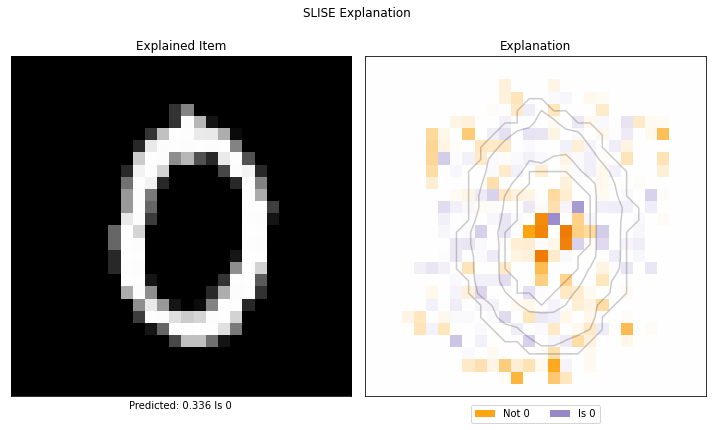

In [175]:
explanation.plot_image(28, 28, classes=["Not " + str(digit), "Is " + str(digit)])

Here we can see that the distinguising feature of zeros is the "hole" in the middle (it being black supports the classification). For humans the most obvious feature would be the ring (and it is actually slightly highlighted as a positive indicator in the explanation), but for the model the hole is the easiest to get a confident prediction.

## Altering the Question

Since SLISE uses real data in the explanation process we can answer (explain) different questions just by changing the dataset. For example, we can answer "Why is this image classified as a six and not a nine?" by subsampling the dataset such that it only contains sixes and nines.

In [207]:
digit_a = 6
digit_b = 9
mask = (c_test == digit_a) + (c_test == digit_b)
x_explain = np.reshape(x_test[mask, :, :, :], (-1, 28 * 28))
y_explain = p_test[mask, digit_a] / (p_test[mask, digit_a] + p_test[mask, digit_b])

And here is the selected item:

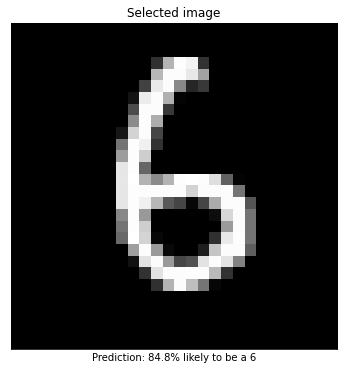

In [212]:
# Select item
item =  np.where(c_test[mask] == digit_a)[0][1]

# Show the selected item
plt.imshow(x_test[mask][item,:,:,0], cmap=BW_COLORMAP)
plt.xticks([])
plt.yticks([])
plt.title("Selected image")
plt.xlabel(f"Prediction: {p_test[mask][item, digit_a] * 100:.1f}% likely to be a {digit_a}")
plt.show()

The explanation is a bit odd, there are two bands with purple above two bands with orange. This makes it seems like the sixes are always higher up than the nines. Since the digits are centered based on the center-of-mass, this is very likely to be the reason.

C:\Users\anton\miniconda3\envs\slise\lib\site-packages\slise\optimisation.py:190: SliseWarning: An optimisation step reaches the maximum number of iterations.
  warn(


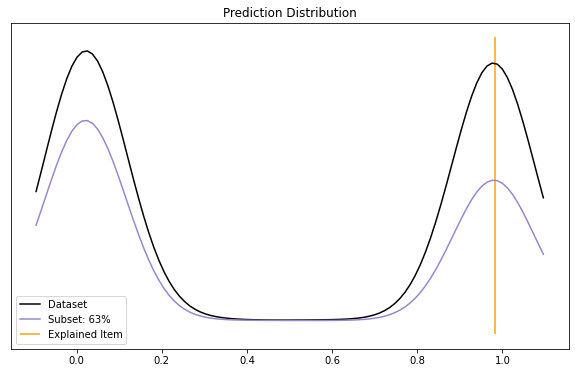

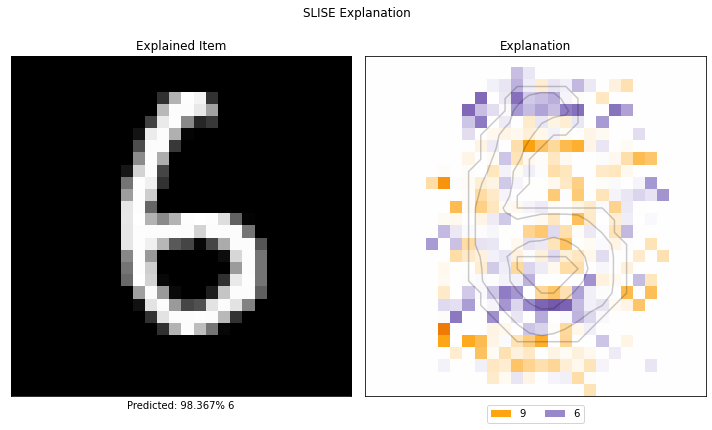

In [216]:
explanation = slise.explain(x_explain, y_explain, 0.4, item, lambda1=0.3, logit=True)
explanation.plot_subset()
explanation.plot_image(28, 28, classes=[str(digit_b), str(digit_a)])

How the model distinguishes between sixes and nines is, thus, based upon a potentially unwanted artifact in the data. To avoid this issue we would have to use some other kind of centering (e.g. by using the [Extended MNIST](https://www.westernsydney.edu.au/icns/reproducible_research/publication_support_materials/emnist) dataset). This demonstrates how explanations can be used to "debug" and improve models.